[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibsonlab/mdsine2_tutorials/blob/main/notebooks/tut_03_cross_validation.ipynb)
# Cross validation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Get data
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/healthy-toy.zip
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/negbin_params.npz
    !curl -LJO https://github.com/gibsonlab/mdsine2_tutorials/raw/main/data/negbin_params.npz
    
    !mkdir -p ./data/
    !unzip -o healthy-toy.zip -d ./data/ 
    !mv negbin_params.npz ./data/

    !git clone https://github.com/gerberlab/MDSINE2
    !pip install MDSINE2/.

else:
    !cd ..

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22392  100 22392    0     0  81722      0 --:--:-- --:--:-- --:--:-- 81722
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   510  100   510    0     0   1153      0 --:--:-- --:--:-- --:--:--  1153
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   510  100   510    0     0   1902      0 --:--:-- --:--:-- --:--:--  1902
Archive:  healthy-toy.zip
  inflating: ./data/health

In [2]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import numpy as np 
from pathlib import Path 
import matplotlib.pyplot as plt 


[DEBUG] Using default logger (stdout, stderr).


In [3]:
data_dir = Path('./data/')
healthy_dir = Path(data_dir / 'healthy-toy')

cv_output_dir = Path('./output/cv')
fig_dir = Path('./figs/')

cv_output_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)

# Make the data and validation Study objects
tsv_files = sorted(healthy_dir.glob('*.tsv'))
tsv_files = {f.stem : f for f in tsv_files}

# Read data into study object
holdout_study = md2.dataset.parse(
    name = healthy_dir.stem,
    metadata = tsv_files['metadata'],
    taxonomy = tsv_files['rdp_species'],
    reads = tsv_files['counts'],
    qpcr = tsv_files['qpcr'],
    perturbations = tsv_files['perturbations'],
)

[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


In [4]:
# Remove subject 4
val_subj_id = 4
val = holdout_study.pop_subject(f'{val_subj_id}')
val.name += '-validate'

print('Holdout study name:', holdout_study.name)
print('Subject IDs in holdout study:', [s.name for s in holdout_study])
print('Perturbations: \n', *holdout_study.perturbations)

print('Validation study name', val.name)
print('Subject IDs in holdout study:', [s.name for s in val])
print('Validation perturbations', *val.perturbations)

# We learned the negative binomial model in the previous tutorial, so
# we'll reuse those parameters here.
negbin_params = np.load(data_dir / 'negbin_params.npz')
a0 = negbin_params['a0'].item()
a1 = negbin_params['a1'].item()
print(f'Reusing a0 and a1 from tutorial 2: a0 = {a0}, a1 = {a1}')

# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / holdout_study.name, 
    seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=holdout_study.name, subjset=holdout_study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)


Holdout study name: healthy-toy
Subject IDs in holdout study: ['2', '3', '5']
Perturbations: 
 Perturbation High Fat Diet:
	Subject 2: (21.5, 28.5)
	Subject 3: (21.5, 28.5)
	Subject 5: (21.5, 28.5)
 Perturbation Vancomycin:
	Subject 2: (35.5, 42.5)
	Subject 3: (35.5, 42.5)
	Subject 5: (35.5, 42.5)
 Perturbation Gentamicin:
	Subject 2: (50.5, 57.5)
	Subject 3: (50.5, 57.5)
	Subject 5: (50.5, 57.5)

Validation study name unnamed-study-validate
Subject IDs in holdout study: ['4']
Validation perturbations Perturbation High Fat Diet:
	Subject 4: (21.5, 28.5)
 Perturbation Vancomycin:
	Subject 4: (35.5, 42.5)
 Perturbation Gentamicin:
	Subject 4: (50.5, 57.5)

Reusing a0 and a1 from tutorial 2: a0 = 1.9940356992343302e-10, a1 = 0.07167989872327986
[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 229 qPCR measurements for 3 buckets. Each bucket is 76 measu

[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

In [5]:
# Forward simulate

# Get the initial conditions
subj = val[f'{val_subj_id}']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, 
    initial_conditions=initial_conditions, 
    times=times, 
    simulation_dt=0.01
)


[INFO] 5/50 - 0.48851799964904785
[INFO] 10/50 - 0.4988083839416504
[INFO] 15/50 - 0.6819391250610352
[INFO] 20/50 - 0.797588586807251
[INFO] 25/50 - 0.7974154949188232
[INFO] 30/50 - 0.7516248226165771
[INFO] 35/50 - 0.7262659072875977
[INFO] 40/50 - 0.5837905406951904
[INFO] 45/50 - 0.5260465145111084


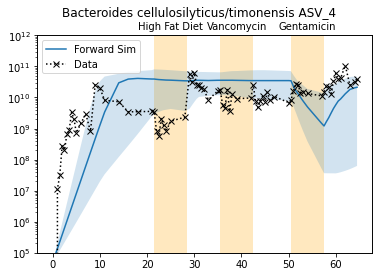

In [6]:
# Plot the forward sims, 5th-95th percentile
taxa = subj.taxa

low = np.percentile(M, q=5, axis=0)
high = np.percentile(M, q=95, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3 # OTU 4

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.savefig(fig_dir / 'forward_sim.png')